In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode as scipy_mode # Используем mode из scipy для лучшей обработки
from datetime import timedelta
import warnings

In [9]:
def calculate_analysis_metrics_sliding_window(df: pd.DataFrame, window_size_minutes: int = 1, rr_interval_precision_ms: int = 10):
    """
    Вычисляет индекс напряженности Баевского (ИН), ЧСС (HR) и ВСР (HRV - RMSSD)
    с использованием скользящего окна.

    Args:
        df: Входной DataFrame с индексом datetime и столбцом 'peaks'.
            Столбец 'peaks' должен содержать логические значения (True/False).
        window_size_minutes: Размер скользящего окна в минутах.
        rr_interval_precision_ms: Точность (размер бина) для расчета моды RR-интервалов в миллисекундах.

    Returns:
        DataFrame со столбцами 'date', 'stress_index', 'HR', 'HRV'.
        'date' - это центральная метка времени окна.
    """
    window_size = timedelta(minutes=window_size_minutes)
    results = []

    # Убедимся, что df имеет datetime индекс
    if not isinstance(df.index, pd.DatetimeIndex):
        timestamp_col = None
        for col in df.columns:
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                timestamp_col = col
                break
            if col.lower() in ["time", "timestamp"]:
                try:
                    df[col] = pd.to_datetime(df[col])
                    timestamp_col = col
                    break
                except:
                    pass
        if timestamp_col:
            df = df.set_index(timestamp_col).sort_index()
        else:
            raise TypeError("Input DataFrame must have a DatetimeIndex or a column convertible to DatetimeIndex.")

    # Убедимся, что столбец 'peaks' существует и содержит булевы значения
    if "peaks" not in df.columns:
        raise ValueError("Input DataFrame must contain a 'peaks' column.")
    if not pd.api.types.is_bool_dtype(df["peaks"]):
        # Попытка преобразовать, если это 0/1
        if df["peaks"].isin([0, 1]).all():
             df["peaks"] = df["peaks"].astype(bool)
        else:
            raise ValueError("'peaks' column must contain boolean values (True/False) or 0/1.")


    peak_timestamps = df.index[df["peaks"]]

    start_time = df.index.min()
    end_time = df.index.max()
    slide_step = timedelta(seconds=1) # Шаг скольжения окна
    current_window_start = start_time

    while current_window_start + window_size <= end_time:
        current_window_end = current_window_start + window_size
        window_center = current_window_start + window_size / 2

        # Фильтруем пики в текущем окне
        window_peaks = peak_timestamps[
            (peak_timestamps >= current_window_start)
            & (peak_timestamps < current_window_end)
        ]

        stress_index = np.nan # Инициализируем ИН как NaN
        hr = np.nan # Инициализируем HR как NaN
        hrv_rmssd = np.nan # Инициализируем HRV как NaN


        # Нужно как минимум 3 пика для 2 RR-интервалов для ИН
        # Для HR и HRV нужно хотя бы 2 пика для 1 RR-интервала
        if len(window_peaks) >= 2:
            # Рассчитываем RR-интервалы в миллисекундах
            sorted_window_peaks = window_peaks.sort_values()
            rr_intervals_ms = sorted_window_peaks.to_series().diff().dropna().dt.total_seconds() * 1000

            if len(rr_intervals_ms) >= 1: # Нужно хотя бы 1 интервал для HR и HRV
                 # Расчет HR (ЧСС)
                average_rr_interval_seconds = rr_intervals_ms.mean() / 1000.0 # в секундах
                if average_rr_interval_seconds > 0:
                    hr = 60.0 / average_rr_interval_seconds

                # Расчет HRV (ВСР) - RMSSD
                if len(rr_intervals_ms) >= 2: # Нужно хотя бы 2 интервала для RMSSD
                    squared_diffs = np.diff(rr_intervals_ms) ** 2
                    if len(squared_diffs) > 0:
                        mean_squared_diffs = np.mean(squared_diffs)
                        hrv_rmssd = np.sqrt(mean_squared_diffs)


            if len(rr_intervals_ms) >= 2 and len(window_peaks) >= 3: # Условия для расчета ИН
                try:
                    # 1. Вариационный размах (ВР)
                    rr_max = rr_intervals_ms.max()
                    rr_min = rr_intervals_ms.min()
                    bp = rr_max - rr_min # ВР в мс

                    if bp > 0: # Избегаем деления на ноль, если все интервалы одинаковы
                        # 2. Мода (Мо) - округляем до заданной точности для группировки
                        rr_intervals_rounded = (rr_intervals_ms / rr_interval_precision_ms).round() * rr_interval_precision_ms
                        mode_result = scipy_mode(rr_intervals_rounded, keepdims=False) # Используем keepdims=False для совместимости со старыми версиями scipy

                        if mode_result.count > 0: # Убедимся, что мода найдена
                            mo = mode_result.mode # Мода в мс

                            if mo > 0: # Избегаем деления на ноль
                                # 3. Амплитуда моды (АМо)
                                amo_count = mode_result.count
                                amo_percent = (amo_count / len(rr_intervals_ms)) * 100 # АМо в %

                                # 4. Индекс Баевского (ИН)
                                # Используем вариант с секундами, он чаще встречается.
                                stress_index = amo_percent / (2 * (mo / 1000) * (bp / 1000))
                        # else: stress_index остается np.nan
                    # else: stress_index остается np.nan
                except Exception as e:
                    print(f"Error calculating stress index at {window_center}: {e}")
                    stress_index = np.nan # Ошибка при расчете

        results.append({"date": window_center, "stress_index": stress_index, "HR": hr, "HRV": hrv_rmssd})
        current_window_start += slide_step

    results_df = pd.DataFrame(results)
    # Заменяем бесконечные значения (если возникли из-за деления на очень малые числа) на NaN
    results_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return results_df

Результаты расчета метрик:
                     date  stress_index         HR         HRV
0 2025-05-02 04:00:00.002     10.776982  89.578528  183.774072
1 2025-05-02 04:00:01.002     10.776982  89.563504  183.669963
2 2025-05-02 04:00:02.002     10.837869  89.442877  184.108540
3 2025-05-02 04:00:03.002     10.776982  89.277504  180.992696
4 2025-05-02 04:00:04.002     10.776982  89.558246  169.922299


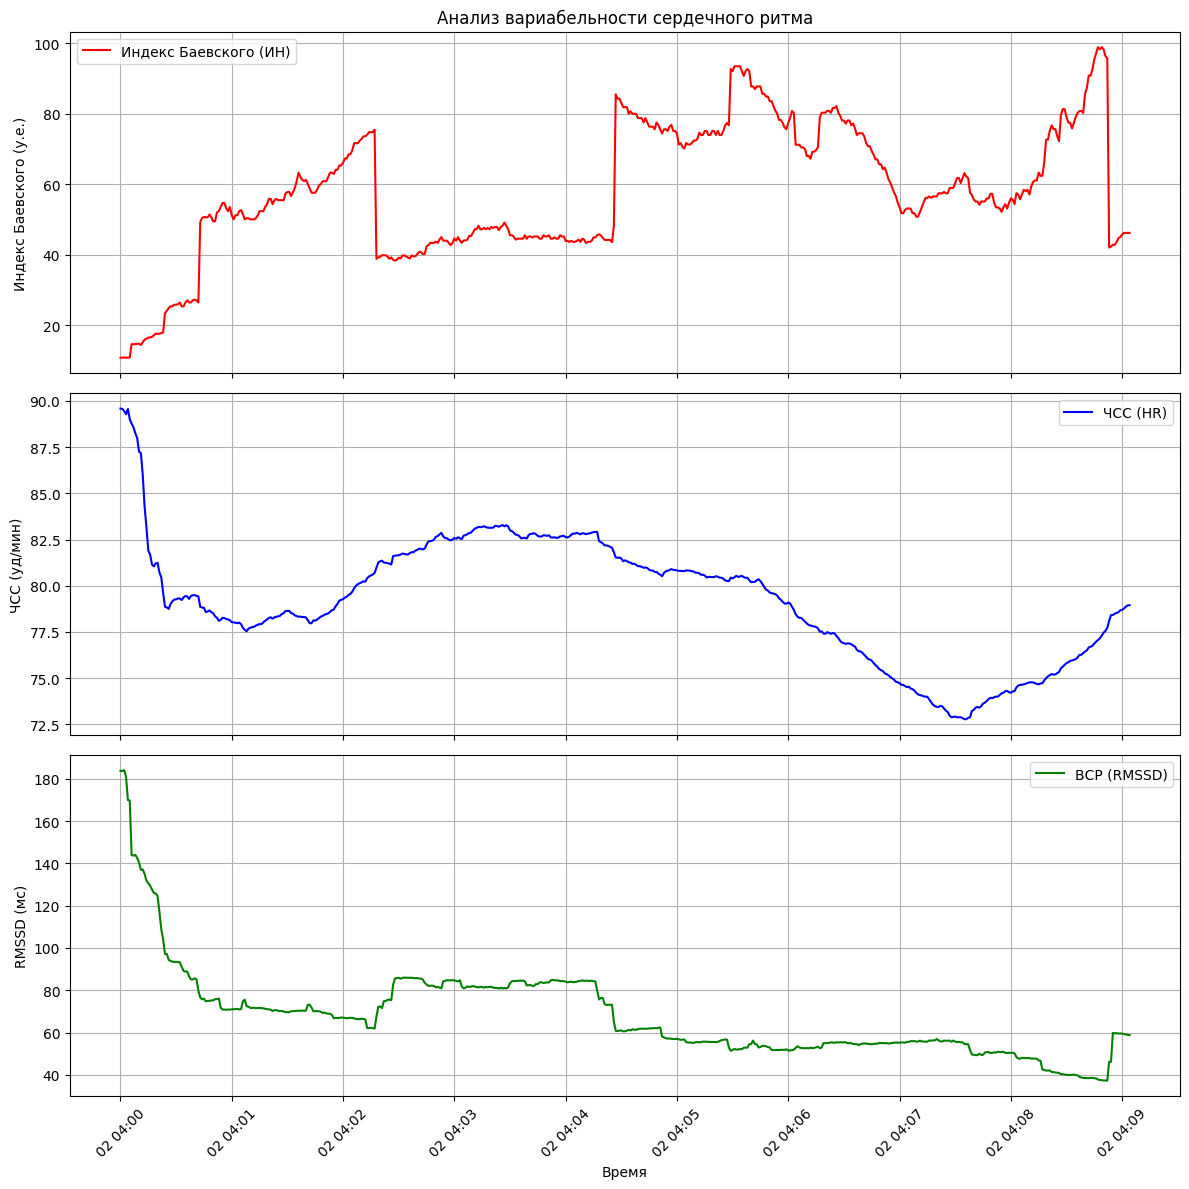

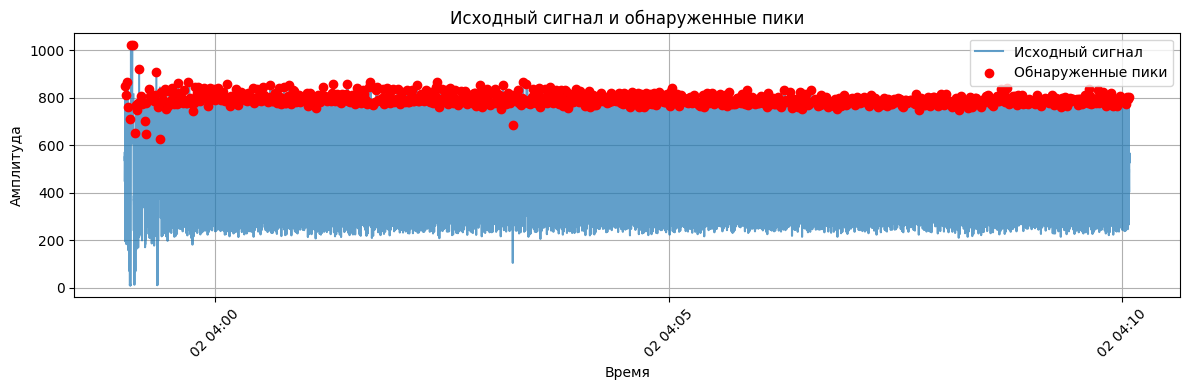

In [10]:
try:
    data = pd.read_csv('com_data/com_fixed_data_20250502_035859_619.csv', parse_dates=['Timestamp'])
except FileNotFoundError:
    print("Ошибка: CSV файл не найден. Убедитесь, что путь 'com_data/com_fixed_data_20250502_035859_619.csv' корректен.")
    exit()

# Выбор короткого интервала для анализа (можно изменить или убрать)
short_data = data[(data['Timestamp'] > '2025-05-02 03:59:00') & (data['Timestamp'] < '2025-05-02 04:10:05')].copy() # Используем .copy() для избежания SettingWithCopyWarning

# Подготовка DataFrame для функции расчета
df_input = pd.DataFrame({
    'Timestamp': short_data['Timestamp'],
    'peaks': short_data['Peaks'].astype(bool) # Убедимся, что тип bool
}).set_index('Timestamp')

# Расчет метрик (ИН, HR, HRV)
# Можно изменить window_size_minutes и rr_interval_precision_ms
analysis_results_df = calculate_analysis_metrics_sliding_window(df=df_input, window_size_minutes=2, rr_interval_precision_ms=50)

# Вывод первых строк результата
print("Результаты расчета метрик:")
print(analysis_results_df.head())

# Построение графиков
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True) # sharex=True для синхронизации оси X

# График Индекса Баевского
axes[0].plot(analysis_results_df['date'], analysis_results_df['stress_index'], label='Индекс Баевского (ИН)', color='red')
axes[0].set_ylabel('Индекс Баевского (у.е.)')
axes[0].set_title('Анализ вариабельности сердечного ритма')
axes[0].legend()
axes[0].grid(True)

# График HR
axes[1].plot(analysis_results_df['date'], analysis_results_df['HR'], label='ЧСС (HR)', color='blue')
axes[1].set_ylabel('ЧСС (уд/мин)')
axes[1].legend()
axes[1].grid(True)

# График HRV (RMSSD)
axes[2].plot(analysis_results_df['date'], analysis_results_df['HRV'], label='ВСР (RMSSD)', color='green')
axes[2].set_xlabel('Время')
axes[2].set_ylabel('RMSSD (мс)')
axes[2].legend()
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

# Дополнительно: график исходного сигнала и пиков для контекста (опционально)
plt.figure(figsize=(12, 4))
plt.plot(short_data['Timestamp'], short_data['COM_Data'], label='Исходный сигнал', alpha=0.7)
plt.scatter(short_data['Timestamp'][short_data['Peaks']], short_data['COM_Data'][short_data['Peaks']], color='red', label='Обнаруженные пики', zorder=5)
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Исходный сигнал и обнаруженные пики")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()